# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy, ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import os
from PIL import Image

from modular_scripts import engine

### Get data 

In [2]:
from pathlib import Path

IMAGE_PATH = Path("data/PizzaSteakSushi")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

### Prepare data

In [3]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Create training and testing DataLoader's as well as get a list of class names
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=simple_transform)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=simple_transform)
class_names = train_data.classes

In [5]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_0 = torchvision.models.efficientnet_b0(weights=weights)

In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seed
torch.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
)

### Train model

In [9]:
# Define loss function, optimizer, and metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=output_shape)

In [10]:
# Set the random seeds
torch.manual_seed(42)

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               metric_fn=metric_fn,
                               results=True
)

Epoch: 0
--------
Train Loss: 1.1033124923706055, Train Acc: 0.37890625 | Test Loss: 0.8905928730964661, Test Acc: 0.5700757503509521
Epoch: 1
--------
Train Loss: 0.9391875863075256, Train Acc: 0.64453125 | Test Loss: 0.8078705668449402, Test Acc: 0.7026515007019043
Epoch: 2
--------
Train Loss: 0.761096179485321, Train Acc: 0.89453125 | Test Loss: 0.6431093215942383, Test Acc: 0.9071969985961914
Epoch: 3
--------
Train Loss: 0.7602061033248901, Train Acc: 0.69921875 | Test Loss: 0.5839809775352478, Test Acc: 0.8967803120613098
Epoch: 4
--------
Train Loss: 0.6309092044830322, Train Acc: 0.88671875 | Test Loss: 0.6012212634086609, Test Acc: 0.9071969985961914


In [11]:
model_0_results

{'train_loss': [tensor(1.1033, grad_fn=<DivBackward0>),
  tensor(0.9392, grad_fn=<DivBackward0>),
  tensor(0.7611, grad_fn=<DivBackward0>),
  tensor(0.7602, grad_fn=<DivBackward0>),
  tensor(0.6309, grad_fn=<DivBackward0>)],
 'train_acc': [tensor(0.3789),
  tensor(0.6445),
  tensor(0.8945),
  tensor(0.6992),
  tensor(0.8867)],
 'test_loss': [tensor(0.8906),
  tensor(0.8079),
  tensor(0.6431),
  tensor(0.5840),
  tensor(0.6012)],
 'test_acc': [tensor(0.5701),
  tensor(0.7027),
  tensor(0.9072),
  tensor(0.8968),
  tensor(0.9072)]}

### Make predictions on the entire test dataset with the model

In [12]:
y_preds = []
model_0.eval()
with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
        y_logit = model_0(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)
        
y_preds_tensor = torch.cat(y_preds)

In [13]:
len(y_preds_tensor), len(test_data)

(75, 75)

In [14]:
y_preds_tensor, torch.tensor(test_data.targets)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
         2, 2, 2]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2]))

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [15]:
confmat = ConfusionMatrix(task="multiclass", num_classes=output_shape)
confmat_tensor = confmat(preds=y_preds_tensor, target=torch.tensor(test_data.targets))

In [16]:
confmat_tensor

tensor([[23,  1,  1],
        [ 1, 16,  2],
        [ 1,  1, 29]])

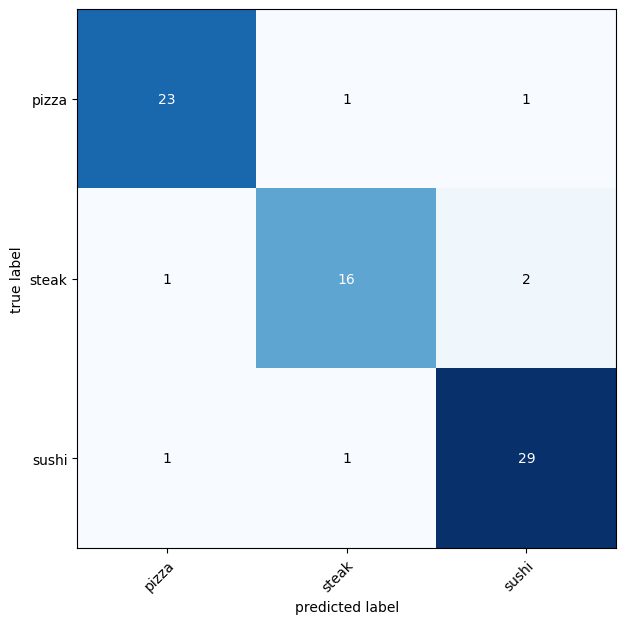

In [17]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # conversion to numpy is needed here
    class_names=class_names,
    figsize=(10,7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [18]:
results = {
    "image_path": [],
    "class_actual": [],
    "class_pred": [],
    "pred_prob": [],
    "correct": []
}

model_0.eval()
with torch.inference_mode():
    for i in test_data.imgs:
        path, label = i
        img = Image.open(path)
        transformed_img = simple_transform(img).unsqueeze(0)
        pred_logit = model_0(transformed_img)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        
        results["image_path"].append(path)
        results["class_actual"].append(class_names[label])
        results["class_pred"].append(class_names[pred_label])
        results["pred_prob"].append(pred_prob.max().item())
        results["correct"].append((label == pred_label).item())

In [19]:
results_df = pd.DataFrame.from_dict(results)

In [20]:
top5 = results_df.loc[results_df["correct"] == False].sort_values(by="pred_prob", ascending=False).head()
top5

,image_path,class_actual,class_pred,pred_prob,correct
70,data\PizzaSteakSushi\test\sushi\684266.jpg,sushi,steak,0.504829,False
27,data\PizzaSteakSushi\test\steak\1285886.jpg,steak,sushi,0.424436,False
12,data\PizzaSteakSushi\test\pizza\2508636.jpg,pizza,steak,0.420367,False
51,data\PizzaSteakSushi\test\sushi\175783.jpg,sushi,pizza,0.390239,False
29,data\PizzaSteakSushi\test\steak\1627703.jpg,steak,sushi,0.388568,False


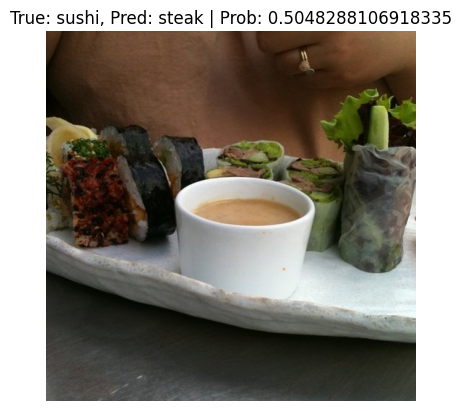

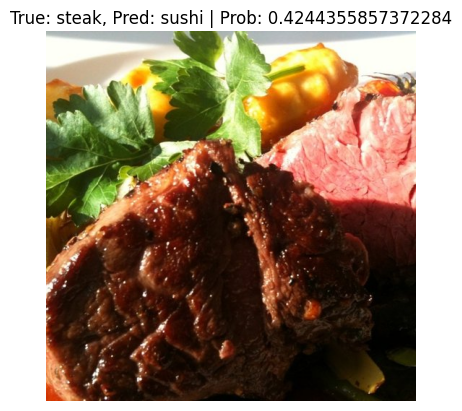

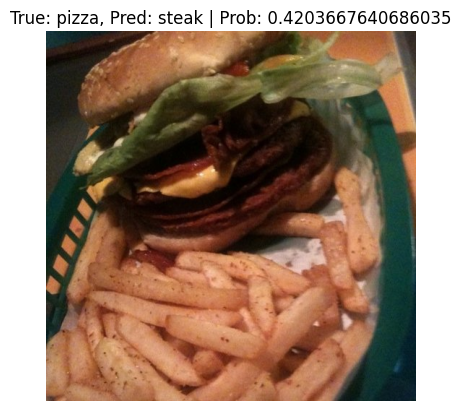

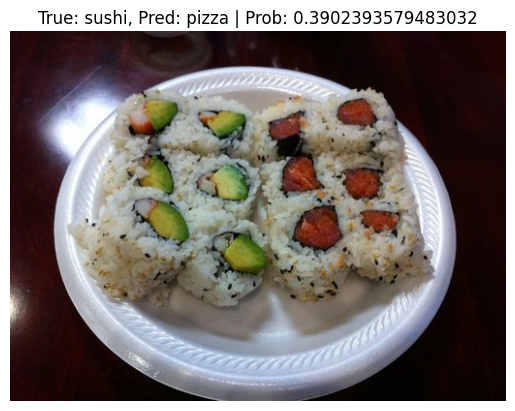

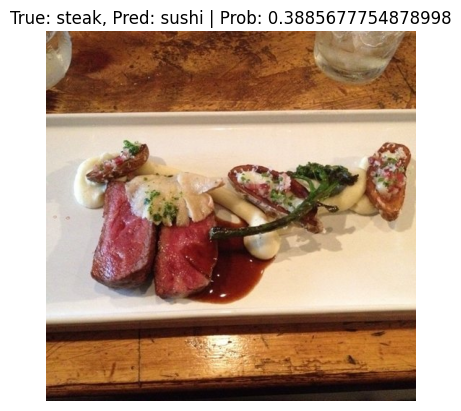

In [21]:
for index, row in top5.iterrows():
    path = row[0]
    class_actual = row[1]
    class_pred = row[2]
    pred_prob = row[3]
    img = Image.open(path)
    plt.figure()
    plt.imshow(img)
    plt.title(f"True: {class_actual}, Pred: {class_pred} | Prob: {pred_prob}")
    plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

Pred Class: pizza | Pred Prob: 0.720


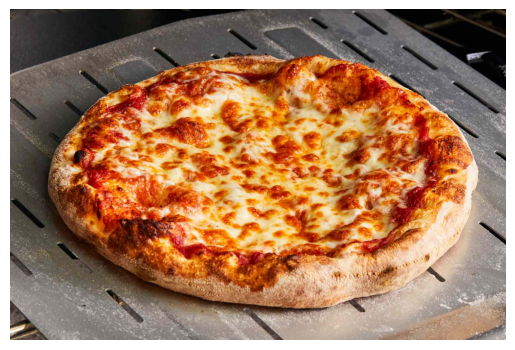

In [22]:
# TODO: Get an image of pizza/steak/sushi
custom_img = Image.open("images/04_pizza.jpg")
model_0.eval()
with torch.inference_mode():
    trns_img = simple_transform(custom_img).unsqueeze(0)
    pred_logit = model_0(trns_img)
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    
    print(f"Pred Class: {class_names[pred_label]} | Pred Prob: {pred_prob.max():.3f}")
    plt.figure()
    plt.imshow(custom_img)
    plt.axis(False);

Pred Class: steak | Pred Prob: 0.501


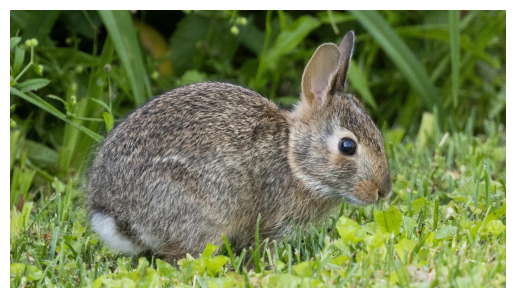

In [23]:
# TODO: Get an image of not pizza/steak/sushi
wrong_img = Image.open("images/06_rabbit.jpg")
model_0.eval()
with torch.inference_mode():
    trns_img = simple_transform(wrong_img).unsqueeze(0)
    pred_logit = model_0(trns_img)
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    
    print(f"Pred Class: {class_names[pred_label]} | Pred Prob: {pred_prob.max():.3f}")
    plt.figure()
    plt.imshow(wrong_img)
    plt.axis(False);

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [24]:
# TODO: Recreate a new model 
torch.manual_seed(42)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights)

for param in model_1.features.parameters():
    param.requires_grad = False

model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=output_shape)

In [26]:
# TODO: Train the model for 10 epochs
torch.manual_seed(42)

model_1_results = engine.train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               metric_fn=metric_fn,
                               results=True
)

Epoch: 0
--------
Train Loss: 1.0701045989990234, Train Acc: 0.421875 | Test Loss: 0.8713169693946838, Test Acc: 0.6818181872367859
Epoch: 1
--------
Train Loss: 0.9052249193191528, Train Acc: 0.65234375 | Test Loss: 0.7976162433624268, Test Acc: 0.7632575631141663
Epoch: 2
--------
Train Loss: 0.7625508308410645, Train Acc: 0.87890625 | Test Loss: 0.6264542937278748, Test Acc: 0.9270833134651184
Epoch: 3
--------
Train Loss: 0.7502378225326538, Train Acc: 0.7265625 | Test Loss: 0.5737206339836121, Test Acc: 0.9270833134651184
Epoch: 4
--------
Train Loss: 0.6059504151344299, Train Acc: 0.8828125 | Test Loss: 0.6025786399841309, Test Acc: 0.876893937587738
Epoch: 5
--------
Train Loss: 0.5841990113258362, Train Acc: 0.9140625 | Test Loss: 0.5457955002784729, Test Acc: 0.8967803120613098
Epoch: 6
--------
Train Loss: 0.5734002590179443, Train Acc: 0.80078125 | Test Loss: 0.5678120255470276, Test Acc: 0.876893937587738
Epoch: 7
--------
Train Loss: 0.49457848072052, Train Acc: 0.8046875 

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [27]:
# Setup path to data folder
IMAGE_PATH = Path("data/PizzaSteakSushi20Percent")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

### Create DataLoaders

In [28]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights)

In [29]:
# Create a transforms pipeline
auto_transforms = weights.transforms()
auto_transforms, type(auto_transforms)

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 torchvision.transforms._presets.ImageClassification)

In [30]:
# Create training and testing DataLoader's as well as get a list of class names
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=auto_transforms)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=auto_transforms)

train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)

In [31]:
for param in model_2.features.parameters():
    param.requires_grad = False

In [32]:
torch.manual_seed(42)
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))

### Train a model with 20% of the data

In [34]:
# TODO: Train the model for 10 epochs
torch.manual_seed(42)

model_2_results = engine.train(model=model_2,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               metric_fn=metric_fn,
                               results=True
)

Epoch: 0
--------
Train Loss: 0.9854094386100769, Train Acc: 0.5583333373069763 | Test Loss: 0.6649057269096375, Test Acc: 0.8755682110786438
Epoch: 1
--------
Train Loss: 0.6941624283790588, Train Acc: 0.8208333253860474 | Test Loss: 0.5540369153022766, Test Acc: 0.8914772868156433
Epoch: 2
--------
Train Loss: 0.5767756700515747, Train Acc: 0.875 | Test Loss: 0.4609866142272949, Test Acc: 0.8818181753158569
Epoch: 3
--------
Train Loss: 0.4579298198223114, Train Acc: 0.887499988079071 | Test Loss: 0.4203718304634094, Test Acc: 0.9096590876579285
Epoch: 4
--------
Train Loss: 0.45811620354652405, Train Acc: 0.856249988079071 | Test Loss: 0.3892415463924408, Test Acc: 0.8943182229995728
